In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm_notebook
from itertools import product

warnings.filterwarnings("ignore")
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["axes.grid"] = False

In [3]:
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
country

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland
...,...,...,...
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe
2013-07-01,17.000,0.453,Zimbabwe


,AverageTemperature
dt,
1825-01-01,25.552167
1826-01-01,25.365000
1827-01-01,25.365000
1828-01-01,25.365000
1829-01-01,25.365000
...,...
2009-01-01,26.455000
2010-01-01,26.537000
2011-01-01,26.202250


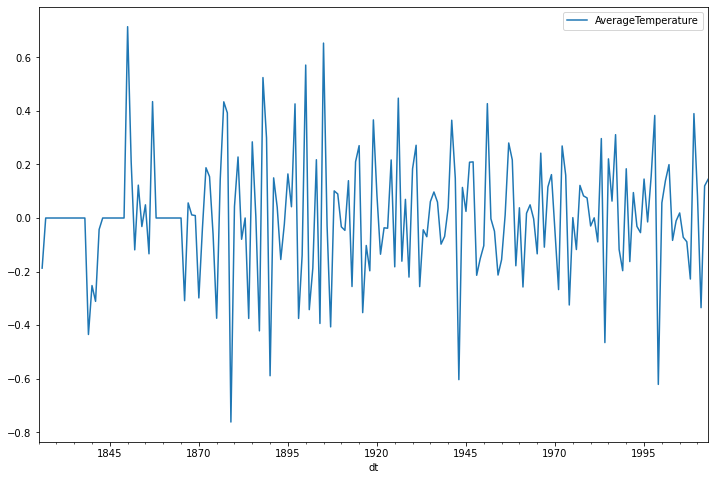

In [4]:
# filtering the dataframe to show only Indonesia
indo = country.copy()
indo = indo.loc[indo["Country"] == "Indonesia"]
indo.fillna(method='bfill', inplace=True)

# resampling the data to show the average temp of each decade
filtered = indo.resample("AS").mean()
filtered.drop("AverageTemperatureUncertainty", axis=1, inplace=True)

# first order of differentials
filtered.diff().plot(figsize=(12,8))
filtered

In [5]:
# checking the stationarity of the time series using Augmented Dicky-Fuller test
# finding the p value to proceed with differencing
# since p-value is larger than chosen threshold (5%), time series is not stationary
result = adfuller(filtered.AverageTemperature)
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])

ADF Statistic: -1.155791
p-value: 0.692318


In [6]:
# splitting the dataset into train, validation, and test dataset
# using 75:15:10 ratio
n = len(filtered)
train, validation, test = filtered[0:int(n*0.75)], filtered[int(n*0.75):int(n*0.9)], filtered[int(n*0.9):]

In [36]:
def optimize_SARIMAX(order_list, exog, seasonal_order=(1,1,1,12)):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order, seasonal_order=seasonal_order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])

        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [37]:
# checking the best ARIMA model
ps = range(0, 8, 1)
d = range(0, 8, 1)
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

# for seasonal_order
seasonal_parameter = product(ps, qs)
seasonal_parameter_list = list(seasonal_parameter)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_SARIMAX(order_list, filtered)

results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(1, 1, 6)",-6.872398
1,"(2, 1, 5)",-5.831074
2,"(2, 1, 4)",-4.609334
3,"(3, 1, 3)",-4.566161
4,"(1, 1, 7)",-4.496407
...,...,...
59,"(7, 1, 1)",1.965774
60,"(0, 1, 1)",2.218216
61,"(7, 1, 2)",3.437159
62,"(1, 1, 0)",14.146223


In [38]:
# according to the test above, the best model is the 116 model
model = SARIMAX(filtered, order=(1,1,6), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  189
Model:             SARIMAX(1, 1, 6)x(1, 1, [1], 12)   Log Likelihood                  13.436
Date:                              Fri, 14 Jan 2022   AIC                             -6.872
Time:                                      18:11:43   BIC                             24.832
Sample:                                  01-01-1825   HQIC                             5.987
                                       - 01-01-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7903      0.125      6.298      0.000       0.544       1.036
ma.L1         -1.20

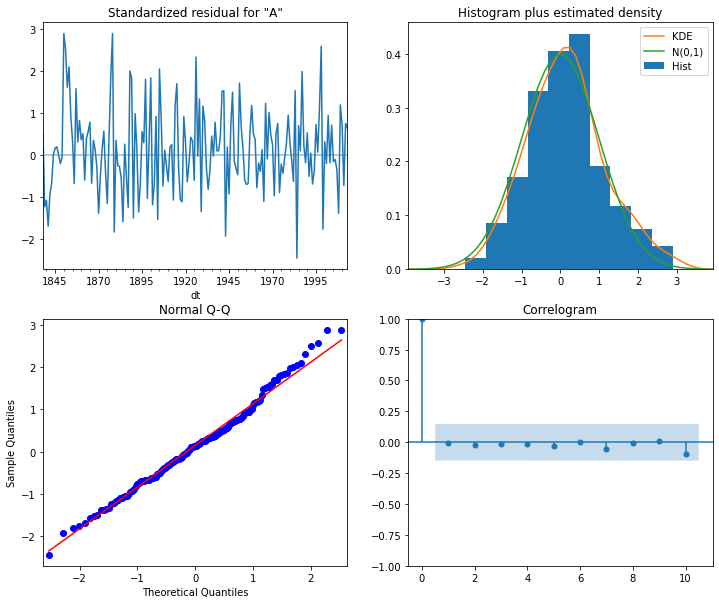

In [39]:
# residuals plot
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

Exception ignored in: <function tqdm.__del__ at 0x000002B0B0804160>
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\User\anaconda3\lib\site-packages\tqdm\notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


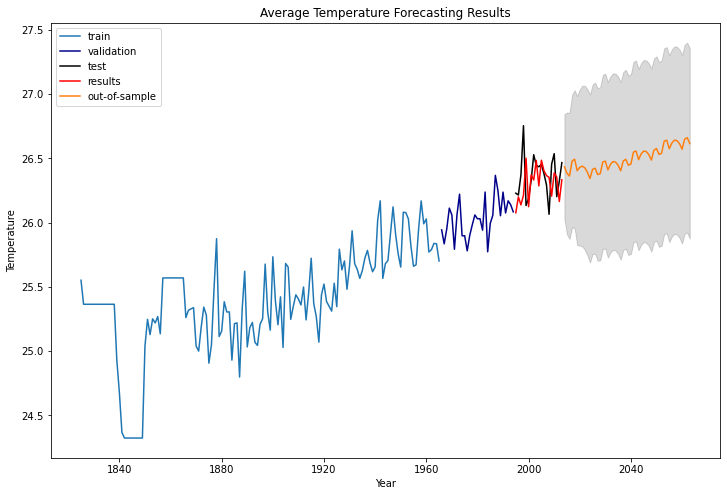

In [41]:
# plotting the in-sample prediction
results = model_fit.predict(start=int(n*0.9))
forecast = model_fit.get_forecast(steps=50)
conf_int = forecast.conf_int(alpha=0.05)
out_of_sample = forecast.predicted_mean

# confidence intervals
lower_bound = pd.Series(conf_int.iloc[:,0])
upper_bound = pd.Series(conf_int.iloc[:,1])

plt.figure(figsize=(12, 8))
plt.plot(train, label="train")
plt.plot(validation, label="validation", color="darkblue")
plt.plot(test, label="test", color="black")
plt.plot(results, label="results", color="red")
plt.plot(out_of_sample, label="out-of-sample")
plt.fill_between(lower_bound.index, lower_bound, upper_bound, color="k", alpha=.15)
plt.title("Average Temperature Forecasting Results")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend(loc="upper left")
plt.show()

In [42]:
# regression analysis
def pred_accuracy(prediction, actual):
    mae = np.mean(np.abs(prediction-actual))
    mape = np.mean(np.abs(prediction-actual) / np.abs(actual))
    mpe = np.mean((prediction-actual)/actual)
    rmse = np.mean((prediction - actual)**2)**0.5
    return {"MAPE" : mape, "MPE" : mpe, "MAE" : mae, "RMSE" : rmse}

pred_accuracy(results.values, test.values)

{'MAPE': 0.006366792060604497,
 'MPE': -0.00200855089161944,
 'MAE': 0.16807393109971627,
 'RMSE': 0.21103425072773357}

[26.43494770533971, 26.384016970262437, 26.36330233875275, 26.479284152322354, 26.493590723044335, 26.404518759340682, 26.42999712656146, 26.44027346793006, 26.42593767982183, 26.39225294799814, 26.34322826617205, 26.415216645123664, 26.423782838119816, 26.3743737224634, 26.381035286868517, 26.472339555502558, 26.478856544863312, 26.410709785392626, 26.453798798543993, 26.475537504242617, 26.47112208236103, 26.446874493950617, 26.40358502594506, 26.480362041538424, 26.493128630085412, 26.446909463454126, 26.456202788827888, 26.549390730470247, 26.557445928842156, 26.490629453742276, 26.53477429829447, 26.557336999238615, 26.553576405907357, 26.529853073037966, 26.486970612704408, 26.564070359196307, 26.577093754083347, 26.531076985187823, 26.540530728654222, 26.633844613192956, 26.64199955040233, 26.575262381507674, 26.619469918570495, 26.642082119446957, 26.638360659844707, 26.614668281801976, 26.571810253218167, 26.64892931196426, 26.661967976192162, 26.615963271863283]


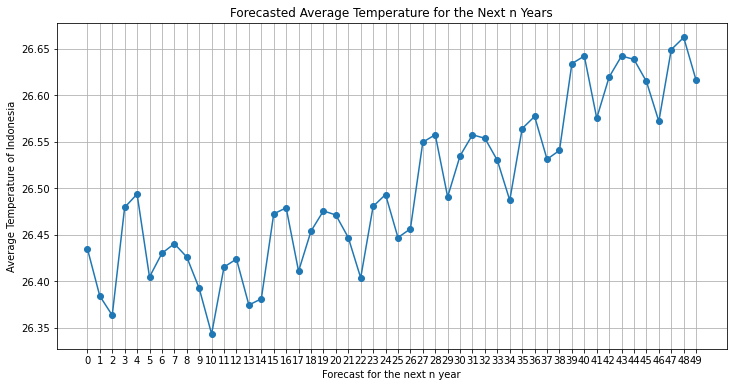

In [43]:
forecast = model_fit.forecast(steps=50)
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("Forecast for the next n year")
plt.ylabel("Average Temperature of Indonesia")
plt.title("Forecasted Average Temperature for the Next n Years")
plt.grid()
print(forecast_values)